In [155]:
import os
import re
import zipfile

import numpy as np

import matplotlib.pyplot as plt
#import tensorflow_datasets as tfds
import pandas as pd

from PIL import Image, ImageFilter, ImageFont, ImageDraw
import ast
import json
from glob import glob

import cv2

In [13]:
#padded_image_shape = (1024, 1920)
min_stride = 128
padded_image_shape = (128*4, 128*8)
anchor_k = 9
num_classes = 80#
num_classes_real = 30
max_data_m = 50#00
use_zoom_up_data = False
level_start = 4
level_end = 8
l1 = 1e-9
activation = 'swish'#'selu' is not converted to tflite

edgecolors = np.random.rand(num_classes, 3) 
edgecolors = np.minimum(edgecolors+0.1, 1.0)
#class_names = ['bg', 'pig', 'crow']
class_names_kor = ['', '모름', '돼지', '멧돼지', '큰부리까마귀', '흰배지빠귀', '유리딱새', '동고비', 
               '박새', '호랑지빠귀', '검독수리', '너구리', '설치류', '다람쥐', '사람']
class_names = ['bg','unknown', 'pig', 'boar', 'crow', 'bird_white', 'bird_ddak', 'bird_dong', 
               'bird_bak', 'bird_tire', 'bird_eagle', 'racoon', 'rat', 'squrrel', 'human']

folder_pig = '/home/mvlab/Downloads/dataset/pig/'

path_weight = "retinanet/pig_efficient_det_BiFPN_D3"
os.path.isdir(folder_pig)

True

In [14]:
folder_pig

'/home/mvlab/Downloads/dataset/pig/'

In [15]:
def add_folder_to_file_name(folder_pig, path_csv):
    path_csv = folder_pig + path_csv
    path_weight = "retinanet/pig_efficient_det_BiFPN_D3"
    print(os.path.isdir(folder_pig), os.path.isfile(path_csv))
    if os.path.isfile(path_csv):
        if path_csv.endswith('csv'):
            df = pd.read_csv(path_csv)
        else:
            df = pd.read_excel(path_csv)
        df['filename'] = folder_pig + df['filename']
        print('df', df.shape, df['filename'].nunique(), df['region_attributes'].nunique()  )
        print(df['region_attributes'].unique())
        return df
    else:
        return None

df1 = add_folder_to_file_name(folder_pig + 'object1/', 'box1.csv')
df2 = add_folder_to_file_name(folder_pig + 'object2/', 'box2.xlsx')
df3 = add_folder_to_file_name(folder_pig + 'object3/', 'box3.csv')#219
df4 = add_folder_to_file_name(folder_pig + 'object4/', 'box4.csv')
df5 = add_folder_to_file_name(folder_pig + 'object5/', 'box5.csv')
df6 = add_folder_to_file_name(folder_pig + 'object6/', 'box6.csv')


True True
df (3451, 7) 1980 11
['{"class":"돼지"}' '{"class":"사람"}' '{"class":"모름"}' '{}' '{"class":"멧돼지"}'
 '{"class":"흰배지빠귀"}' '{"class":"큰부리까마귀"}' '{"class":"다람쥐"}'
 '{"class":"호랑지빠귀"}' '{"class":"설치류"}' '{"class":"유리딱새"}']
True True
df (855, 7) 402 9
['{"class":"사람"}' '{"class":"모름"}' '{"class":"돼지"}' '{"class":"큰부리까마귀"}'
 '{"class":"유리딱새"}' '{"class":"흰배지빠귀"}' '{"class":"동고비"}'
 '{"class":"다람쥐"}' '{"class":"멧돼지"}']
True True
df (6714, 7) 4314 10
['{"class":"돼지"}' '{"class":"모름"}' '{"class":"사람"}' '{"class":"유리딱새"}'
 '{"class":"동고비"}' '{"class":"흰배지빠귀"}' '{"class":"설치류"}'
 '{"class":"큰부리까마귀"}' '{"class":"너구리"}' '{}']
True True
df (6519, 7) 1849 11
['{"class":"사람"}' '{"class":"멧돼지"}' '{"class":"모름"}' '{"class":"큰부리까마귀"}'
 '{"class":"유리딱새"}' '{}' '{"class":"돼지"}' '{"class":"너구리"}'
 '{"class":"설치류"}' '{"class":"흰배지빠귀"}' '{"class":"호랑지빠귀"}']
True True
df (1777, 7) 693 6
['{"class":"사람"}' '{"class":"멧돼지"}' '{"class":"큰부리까마귀"}' '{"class":"모름"}'
 '{"class":"너구리"}' '{"class":"돼지"}']
True Tru

In [16]:
#df = pd.concat((df1, df2, df3, df4, df5, df6), axis=0)
df = df1
df.shape

(3451, 7)

In [17]:
df.head()

,filename,file_size,file_attributes,region_count,region_id,region_shape_attributes,region_attributes
0,/home/mvlab/Downloads/dataset/pig/object1/geom...,362254,{},2,0,"{""name"":""rect"",""x"":583,""y"":463,""width"":453,""he...","{""class"":""돼지""}"
1,/home/mvlab/Downloads/dataset/pig/object1/geom...,362254,{},2,1,"{""name"":""rect"",""x"":560,""y"":563,""width"":224,""he...","{""class"":""사람""}"
2,/home/mvlab/Downloads/dataset/pig/object1/geom...,365469,{},2,0,"{""name"":""rect"",""x"":907,""y"":332,""width"":211,""he...","{""class"":""사람""}"
3,/home/mvlab/Downloads/dataset/pig/object1/geom...,365469,{},2,1,"{""name"":""rect"",""x"":584,""y"":457,""width"":369,""he...","{""class"":""사람""}"
4,/home/mvlab/Downloads/dataset/pig/object1/geom...,362131,{},2,0,"{""name"":""rect"",""x"":339,""y"":128,""width"":107,""he...","{""class"":""사람""}"


In [18]:
annotation = dict()
object_width_list = []
for i in range(len(df)):
    
    sample_row = df.iloc[i]
    filename = sample_row['filename']    
    region_id = sample_row['region_id']
    box = sample_row['region_shape_attributes']    
    region_attributes = sample_row['region_attributes']    
        
    try:
        box_map = ast.literal_eval(box)    
        region_attributes = ast.literal_eval(region_attributes)        
        
    except:
        print('filename', filename)
        print('box', box)
        print('region_attributes', region_attributes)
        continue
        #exit()
    
    if '(' in filename:
        print(' ( )', filename)
        continue
    if len(box_map.keys())<1 or len(region_attributes.keys())<1 :
        #print(i, 'no_keys_skip', filename.split(os.sep)[-1])
        continue
        
    cls = region_attributes['class']
    if cls in class_names_kor:
        cls_num = class_names_kor.index(cls)
    elif cls in class_names:
        cls_num = class_names.index(cls)
    else:
        print('cls unknown', cls)
        continue
        
    x0 = box_map['x']
    y0 = box_map['y']
    width = box_map['width']
    height = box_map['height']    
   
    object_width_list.append(width)    
    bbox = [cls_num, x0, y0, x0 + width, y0 + height]
    
    if filename not in annotation.keys():
        annotation[filename] = []
    
    annotation[filename].append(bbox)            
    #print(i, df.loc[i, 'filename'], width, height)

In [19]:
len(annotation)

1371

In [20]:
len(object_width_list), np.min(object_width_list), np.mean(object_width_list), np.max(object_width_list)

(2822, 22, 451.50673281360736, 1651)

(array([1289.,  145.,   61.,   39.,  819.,  461.,    2.,    2.,    2.,
           2.]),
 array([  22. ,  184.9,  347.8,  510.7,  673.6,  836.5,  999.4, 1162.3,
        1325.2, 1488.1, 1651. ]),
 <a list of 10 Patch objects>)

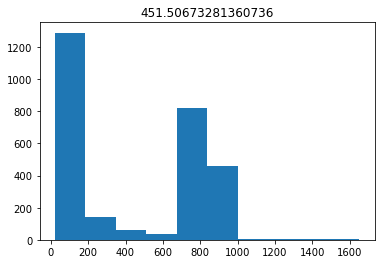

In [21]:
plt.title(str(np.mean(object_width_list)))
plt.hist(object_width_list)

In [131]:
input_list = []
bbox_list = []
path_list = []
for key in annotation:
    cls_bbox = annotation[key]
    cls_bbox = np.array(cls_bbox).reshape([-1, 5])
    cls = cls_bbox[:, 0:1]
    bbox = np.array(cls_bbox[:, 1:])
        
    path_image = key
    if os.path.isfile(path_image):
        img = Image.open(path_image)    
        scale = np.array((img.width, img.height, img.width, img.height))
        scale = np.reshape(scale, (1, 4))       
        #print(key, cls, cls_bbox.dtype, cls_bbox, 'wh',img.width, img.height)
        
        bbox_norm = bbox.astype(np.float) / scale.astype(np.float)
        cls_bbox_norm = np.concatenate((cls, bbox_norm), axis=1)

        input_list.append(img)
        bbox_list.append(cls_bbox_norm)
        path_list.append(key)
        if len(input_list)%100==0:        
            print(len(annotation), len(input_list), len(bbox_list))   
    else:
        print('not exist', path_image)

print(len(input_list), len(bbox_list))

1371 100 100
1371 200 200
1371 300 300
1371 400 400
1371 500 500
1371 600 600
1371 700 700
1371 800 800
1371 900 900
1371 1000 1000
1371 1100 1100
1371 1200 1200
1371 1300 1300
1371 1371


(2822, 5)


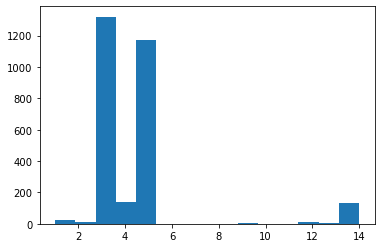

In [23]:
cbbox = np.concatenate(bbox_list, 0)
print(cbbox.shape)
h = plt.hist(cbbox[:, 0], bins=len(class_names))

In [24]:
cbbox.shape

(2822, 5)

In [25]:
def crop_bbox_image(image, boxes):
    img_objects = []
    image = np.array(image)
    for box in boxes:        
        box = box.astype(np.int)
        x1, y1, x2, y2 = box
        w = x2 - x1
        h = y2 - y1        
        crop_image_arr = image[y1:y2, x1:x2]
        ch, cw, cc = crop_image_arr.shape
        if ch>1 and cw>1:
            img_objects.append(crop_image_arr)
        else:
            print('crop_bbox_image', x2-x1, y2-y1, 'crop_image_arr.shape', crop_image_arr.shape)
        
    return img_objects
    
    
def attach_crop_image(image, boxes, max_crop=200):
        
    crop_bbox_arr = crop_bbox_image(image, np.array(boxes)[:max_crop])
    bbox_k = len(crop_bbox_arr)
    max_col = 30
    
    if bbox_k > 0:
        img_h, img_w, img_c = image.shape
        object_img_w = img_w//bbox_k        
        resize_h = img_h // 8
        resize_w = img_w // bbox_k  
        resize_w = min(max(resize_w, img_w//max_col), img_w//8)
        
        footer_h = resize_h * (1 + (bbox_k-1)//max_col)
        footer = np.zeros((footer_h, img_w, img_c), np.uint8)
        
        for i in range(min(bbox_k, max_crop)):
            crop_arr = crop_bbox_arr[i]
            crop_img = Image.fromarray(crop_arr)                
            crop_img = crop_img.resize((resize_w, resize_h))
            crop_arr_resized = np.array(crop_img)
            offset_y = (i//max_col) * resize_h
            offset_x = (i%max_col) * resize_w
            footer[offset_y:offset_y+resize_h, offset_x:offset_x+resize_w] = crop_arr_resized

        seperate_line = np.zeros_like(footer[:2])
        image = np.concatenate((image, seperate_line, footer), axis=0)    
    return image    

In [27]:
def visualize_detections_simple(
    image, boxes, classes, i, is_save=False, linewidth=1):
    """Visualize Detections"""
        
    image = np.array(image, dtype=np.uint8)        
    img_h, img_w, img_c = image.shape    
    image = attach_crop_image(image, boxes, max_crop=100)
    
    plt.figure(figsize=(12, 12))
    plt.axis("off")
    plt.imshow(image)
    ax = plt.gca()
    boxes_width = boxes[:, 2] - boxes[:, 0]
    boxes_height = boxes[:, 3] - boxes[:, 1]
    box_min_width = np.min(boxes_width)
    box_max_width = np.max(boxes_width)
    title = str.format('(%dx%d) %d box, width:%d ~ %d' 
                       %(img_h, img_w, len(boxes), box_min_width, box_max_width))
    plt.title(title)            
    
    for box, cls in zip(boxes, classes):
        x1, y1, x2, y2 = box        
        w, h = x2 - x1, y2 - y1
        color = edgecolors[int(cls)]
        patch = plt.Rectangle(
            [x1, y1], w, h, fill=False, edgecolor=color, linewidth=linewidth
        )
        ax.add_patch(patch)
        if len(boxes) < 70:
            score_txt = class_names[int(cls)]
            ax.text(x1, y1, score_txt, bbox={"facecolor": [1,1,0], "alpha": 0.4}, clip_box=ax.clipbox, clip_on=True,)
    
    if is_save:
        plt.savefig('./fig/'+str(i)+'.jpg',  bbox_inches='tight', pad_inches=0)
    plt.show()
    return ax

In [ ]:
def display_data(X, BBOX, stride=1, is_save=False):
    
    for i in range(len(X)):
        if i%stride==0:
            img_arr = X[i]
            sample_box = BBOX[i]
            label = sample_box[:, 0]
            bbox = sample_box[:, 1:]

            h, w, c = img_arr.shape
            scale = np.array((w, h, w, h))
            scale = np.reshape(scale, (1, 4))
            bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
            #print('bbox_norm', bbox, bbox_norm)
            print(i, np.unique(label))
            classes = np.array(label).astype(np.int)
            class_max = np.max(classes)
            if class_max>= class_names.index('human'):
                continue
            if not np.any(classes >= class_names.index('crow')):
                continue
            ax = visualize_detections_simple(img_arr,bbox_norm,label, i, is_save)            

In [47]:
m = len(input_list)
print('m', m)

m 1371


In [151]:
def save_as_video(X, Y, stride=1):
    for i in range(0, len(X), stride):
    
        img = X[i].copy()        
        sample_box = Y[i]
        label = sample_box[:, 0]
        bbox = sample_box[:, 1:]
        
        draw = ImageDraw.Draw(img)
        w, h = img.size
        scale = np.array((w, h, w, h)).reshape((1, 4))
        bbox_norm = bbox.astype(np.float) * scale.astype(np.float)
        bbox_int = bbox_norm.astype(np.int)
        label = label.astype(np.int)
                
        classes = np.array(label).astype(np.int)
        class_max = np.max(classes)
        if class_max >= class_names.index('human'):
            continue
        if not np.any(classes >= class_names.index('crow')):
            continue
        
        for cls, box in zip(label, bbox_int):
            if cls >= class_names.index('crow'):
                #print(i, 'cls > 3', cls, box)
                draw.rectangle(list(box), fill=None, outline=None, width=5)
        
        img.save('./fig/'+str(i)+'.jpg',)
        #plt.imshow(img)
        #plt.show()

In [161]:
list_jpg = (glob('./fig/*.jpg'))
len(list_jpg)

1133

In [166]:
file_nums = []
for jpg in list_jpg:
    if os.sep in jpg:
        file_name = jpg.split('/')[-1]
    else:
        file_name = jpg
    file_name = file_name.split('.')[0]
    file_nums.append(int(file_name))
    #print(file_name)

In [169]:
min(file_nums), max(file_nums), len(file_nums)

(131, 1370, 1133)

In [174]:
order = np.argsort(file_nums)
order

array([697, 404, 683, ..., 222, 914, 665])

In [177]:
list_ordered_path = []
for o in order:
    jpg = list_jpg[o]
    list_ordered_path.append(jpg)

In [178]:
list_ordered_path

['./fig/131.jpg',
 './fig/132.jpg',
 './fig/133.jpg',
 './fig/134.jpg',
 './fig/135.jpg',
 './fig/136.jpg',
 './fig/137.jpg',
 './fig/138.jpg',
 './fig/139.jpg',
 './fig/140.jpg',
 './fig/141.jpg',
 './fig/142.jpg',
 './fig/143.jpg',
 './fig/144.jpg',
 './fig/145.jpg',
 './fig/146.jpg',
 './fig/147.jpg',
 './fig/148.jpg',
 './fig/149.jpg',
 './fig/151.jpg',
 './fig/152.jpg',
 './fig/153.jpg',
 './fig/154.jpg',
 './fig/155.jpg',
 './fig/156.jpg',
 './fig/157.jpg',
 './fig/169.jpg',
 './fig/170.jpg',
 './fig/171.jpg',
 './fig/172.jpg',
 './fig/173.jpg',
 './fig/174.jpg',
 './fig/175.jpg',
 './fig/176.jpg',
 './fig/177.jpg',
 './fig/178.jpg',
 './fig/180.jpg',
 './fig/182.jpg',
 './fig/183.jpg',
 './fig/184.jpg',
 './fig/185.jpg',
 './fig/186.jpg',
 './fig/188.jpg',
 './fig/189.jpg',
 './fig/190.jpg',
 './fig/191.jpg',
 './fig/192.jpg',
 './fig/193.jpg',
 './fig/194.jpg',
 './fig/195.jpg',
 './fig/196.jpg',
 './fig/197.jpg',
 './fig/198.jpg',
 './fig/199.jpg',
 './fig/200.jpg',
 './fig/20

In [180]:
def save_image_to_video(paths, dst='project.avi'):
    img_array = []
    for filename in paths:
        img = cv2.imread(filename)
        height, width, layers = img.shape
        size = (width,height)
        img_array.append(img)

    out = cv2.VideoWriter(dst,cv2.VideoWriter_fourcc(*'DIVX'), 15, size)

    for i in range(len(img_array)):
        if i%100==0:
            print(len(img_array), i)
        out.write(img_array[i])
    out.release()

In [181]:
save_image_to_video(list_ordered_path)

1133 0
1133 100
1133 200
1133 300
1133 400
1133 500
1133 600
1133 700
1133 800
1133 900
1133 1000
1133 1100
